# A more complex example

Try to emulate Arnau's analysis

## Visualise the PDFS


{'sig': 23529.411764705885, 'misrec1': 5882.352941176471, 'misrec2': 5882.352941176471, 'partreclow': 5882.352941176471, 'partrechigh': 11764.705882352942, 'bkg': 47058.82352941177}


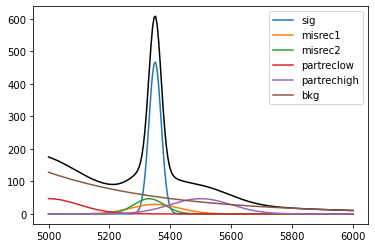

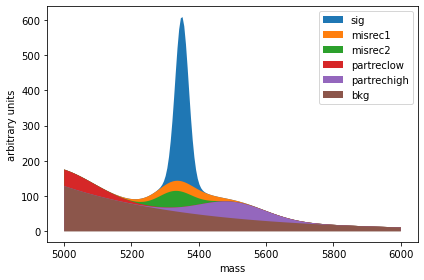

In [1]:
import numpy as np
from scipy.stats import norm, expon, crystalball
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import matplotlib as mpl

# set the default color cycle
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "r", "g", "c", "m", "y"]) 


np.random.seed(1)  # fix seed

# ranges
mrange = (5000,6000)

# tot events
nevents = 100000

# components of the PDF
compnames = ['sig','misrec1','misrec2','partreclow','partrechigh','bkg']

               
pdf_typs = {'sig'          : norm, 
            'misrec1'      : norm,
            'misrec2'      : norm,
            'partreclow'   : crystalball,
            'partrechigh'  : crystalball,
            'bkg'          : expon
          }

pdf_vars = {'sig'          : (5350,20), 
            'misrec1'      : (5350,80),
            'misrec2'      : (5330,50),
            'partreclow'   : (3 , 2 , 5000, 100),
            'partrechigh'  : (3, 2 , 5500, 100),
            'bkg'          : (5000, 400)
          }

pdf_dic = { name: pdf_typs[name](*pdf_vars[name]) for name in compnames}

# frac_yields
frac_ylds = { 'sig'          : 0.2, 
              'misrec1'      : 0.05,
              'misrec2'      : 0.05,
              'partreclow'   : 0.05,
              'partrechigh'  : 0.1,
              'bkg'          : 0.4
          }

# normalise yields
norm_sum = sum(frac_ylds.values())
for name in compnames: frac_ylds[name] /= norm_sum 

# set yields
abs_ylds = { name : frac_ylds[name]*nevents for name in compnames }
print(abs_ylds)

# set normalisations
pdf_norms = { name : np.diff( pdf_dic[name].cdf(mrange))[0] for name in compnames }

# define a pdf function
def pdf(x, comps='all'):
    if comps=='all': comps = compnames
    return sum( [ abs_ylds[comp] * pdf_dic[comp].pdf(x) / pdf_norms[comp] for comp in comps ] )    

# draw the pdf(s)
fig, ax = plt.subplots(1,1, figsize=(6,4))
m = np.linspace(*mrange,200)

ax.plot(m, pdf(m), 'k-' )
for comp in compnames: ax.plot(m, pdf(m,comps=[comp]), label=comp)
ax.legend()

fig, ax = plt.subplots(1,1, figsize=(6,4))
rcomps = list(compnames)
for comp in compnames: 
    ax.fill_between(m, pdf(m, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax.legend()
ax.set_xlabel('mass')
ax.set_ylabel('arbitrary units')
fig.tight_layout()
fig.savefig('figs/ex2_mass.pdf')


17.433259740749016 7.495969587783039


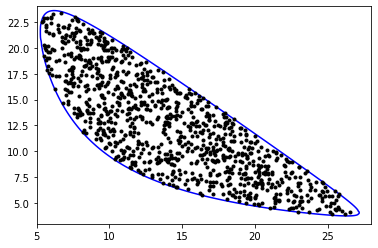

In [2]:
## Need to set up some stuff for the Dalitz distrbutions
class dalitz:
    
    def __init__(self, md, ma, mb, mc):
        self.fMa = ma
        self.fMb = mb
        self.fMc = mc
        self.fMd = md
        self.fM2a = ma*ma
        self.fM2b = mb*mb
        self.fM2c = mc*mc
        self.fM2d = md*md
        self.fM2sum = self.fM2a + self.fM2b + self.fM2c + self.fM2d
        self.abrange = (np.floor((self.fMa + self.fMb)**2) , np.ceil((self.fMd - self.fMc)**2))
        self.bcrange = (np.floor((self.fMb + self.fMc)**2) , np.ceil((self.fMd - self.fMa)**2))
        self.acrange = (np.floor((self.fMa + self.fMc)**2) , np.ceil((self.fMd - self.fMb)**2))
        
    def in_kine_limits(self, m2ab, m2ac):
        #passes = (self.fM2sum < m2ab+m2ac)
        #passes = (m2ab > self.abrange[0]) & (m2ab < self.abrange[1])
        #passes = passes & (m2ab > self.abrange[0]) & (m2ab < self.abrange[1])
        m2bc = self.fM2sum - m2ab -m2ac
        #m2bc[ m2bc < 0 ] = 0
        mab = m2ab**0.5
        mac = m2ac**0.5
        mbc = m2bc**0.5     

        p2a = 0.25/self.fM2d*(self.fM2d-(mbc+self.fMa)**2)*(self.fM2d-(mbc-self.fMa)**2)
        p2b = 0.25/self.fM2d*(self.fM2d-(mac+self.fMb)**2)*(self.fM2d-(mac-self.fMb)**2)
        p2c = 0.25/self.fM2d*(self.fM2d-(mab+self.fMc)**2)*(self.fM2d-(mab-self.fMc)**2)
        #print( p2a, p2b, p2c)
        #passes = passes & (p2a > 0) & (p2b > 0) & (p2c > 0)
        
        eb = (m2ab-self.fM2a+self.fM2b)/2./mab
        ec = (self.fM2d-m2ab-self.fM2c)/2./mab
        if ( eb < self.fMb ) or ( ec < self.fMc ): return False
        #passes = passes & (eb > self.fMb) & (ec > self.fMc)
        
        pb = np.sqrt(eb**2-self.fM2b)
        pc = np.sqrt(ec**2-self.fM2c)
        e2sum = (eb+ec)**2
        m2bc_max = e2sum-(pb-pc)**2
        m2bc_min = e2sum-(pb+pc)**2
        if m2bc < m2bc_min or m2bc > m2bc_max: return False
        if (p2a>0 and p2b>0 and p2c>0): return True
        #passes = passes & (m2bc > m2bc_min) & (m2bc < m2bc_max)
        return False

    def dp_contour(self, x, y, orientation=1323):
        
        mParent = self.fMd
        if orientation == 1323:
            mi = self.fMa
            mj = self.fMb
            mk = self.fMc
        elif orientation == 2313:
            mi = self.fMb
            mj = self.fMa
            mk = self.fMc
        elif orientation == 1213:
            mi = self.fMb
            mj = self.fMc
            mk = self.fMa
        elif orientation == 1312:
            mi = self.fMc
            mj = self.fMb
            mk = self.fMa
        elif orientation == 1223:
            mi = self.fMa
            mj = self.fMc
            mk = self.fMb
        elif orientation == 2312:
            mi = self.fMc
            mj = self.fMa
            mk = self.fMb
        else:
            raise RuntimeError('Invalid orientation', orientation)
                       
        mik = np.sqrt(x)
        mjk = np.sqrt(y)
        
        ejcmsik = (mParent*mParent-mj*mj-mik*mik)/(2.0*mik)
        ekcmsik = (mik*mik+mk*mk-mi*mi)/(2.0*mik)
        
        pj = np.sqrt(np.abs(ejcmsik*ejcmsik-mj*mj))
        pk = np.sqrt(np.abs(ekcmsik*ekcmsik-mk*mk))
        
        coshelik = (mjk*mjk - mk*mk - mj*mj - 2.0*ejcmsik*ekcmsik)/(2.0*pj*pk)
        coshelikSq = coshelik*coshelik
        
        coshelikSq = np.where( ekcmsik < mk , 2. , coshelikSq )
        coshelikSq = np.where( ejcmsik < mj  , 2. , coshelikSq )
        return np.where( np.isnan(coshelikSq), 2., coshelikSq )
    
    def psgen(self, size=1):
        
        res = np.empty((0,2))
        for i in range(size):
            x = np.random.uniform( *self.abrange )
            y = np.random.uniform( *self.acrange )
            while not self.in_kine_limits(x,y):
                x = np.random.uniform( *self.abrange )
                y = np.random.uniform( *self.acrange )
            
            res = np.append(res,[[x,y]],axis=0)
        return res
    
## pretend this is Bs -> D0 K pi
mB = 5.350
mD = 1.800
mK = 0.493
mPi = 0.139

bdkp = dalitz( mB, mD, mK, mPi )

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)
plt.contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
vals = bdkp.psgen(size=1000)
plt.plot(vals[:,0], vals[:,1],'.',color='k')

tx, ty = bdkp.psgen()[0]
print(tx, ty)

In [3]:
## Generate a toy
import pandas as pd

data = pd.DataFrame(columns=['mass','ctrl','m2ab','m2ac'])
#data = pd.DataFrame.astype({'mass':float,'ctrl':int,'m2ab':float,'m2ac':float})



for i, comp in enumerate(compnames):
    nevs = np.random.poisson(abs_ylds[comp])
    ngen = 0
    while ngen<nevs:
        mval = pdf_dic[comp].rvs()
        if mval>=mrange[0] and mval<=mrange[1]:
            ctrl = i
            if ctrl==0:
                x = np.random.normal(10,0.2)
                y = np.random.uniform(*bdkp.acrange)
                while not bdkp.in_kine_limits(x,y):
                    x = np.random.normal(10,0.2)
                    y = np.random.uniform(*bdkp.acrange)
            elif ctrl==4:
                x = np.random.uniform(*bdkp.abrange)
                y = np.random.normal(15,0.4) 
                while not bdkp.in_kine_limits(x,y):
                    x = np.random.uniform(*bdkp.abrange) 
                    y = np.random.normal(15,0.4)
            else:
                x,y = bdkp.psgen()[0]                
                        
            data = data.append( {'mass':mval, 'ctrl': ctrl, 'm2ab':x, 'm2ac':y}, ignore_index=True )            
            ngen += 1
            
print(data)


            

              mass  ctrl       m2ab       m2ac
0      5350.344164   0.0  10.035083  19.672321
1      5352.829888   0.0   9.585293  20.535525
2      5312.754809   0.0   9.960660  13.018519
3      5362.356717   0.0  10.127755  20.027217
4      5369.952230   0.0  10.018305   9.508347
...            ...   ...        ...        ...
99732  5192.490437   5.0   6.237100  21.419750
99733  5191.699186   5.0  20.523029   8.886863
99734  5130.048297   5.0  23.090653   4.508434
99735  5355.826277   5.0  15.290473  13.112904
99736  5028.276446   5.0  17.402181  10.230556

[99737 rows x 4 columns]


/Users/matt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/matt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


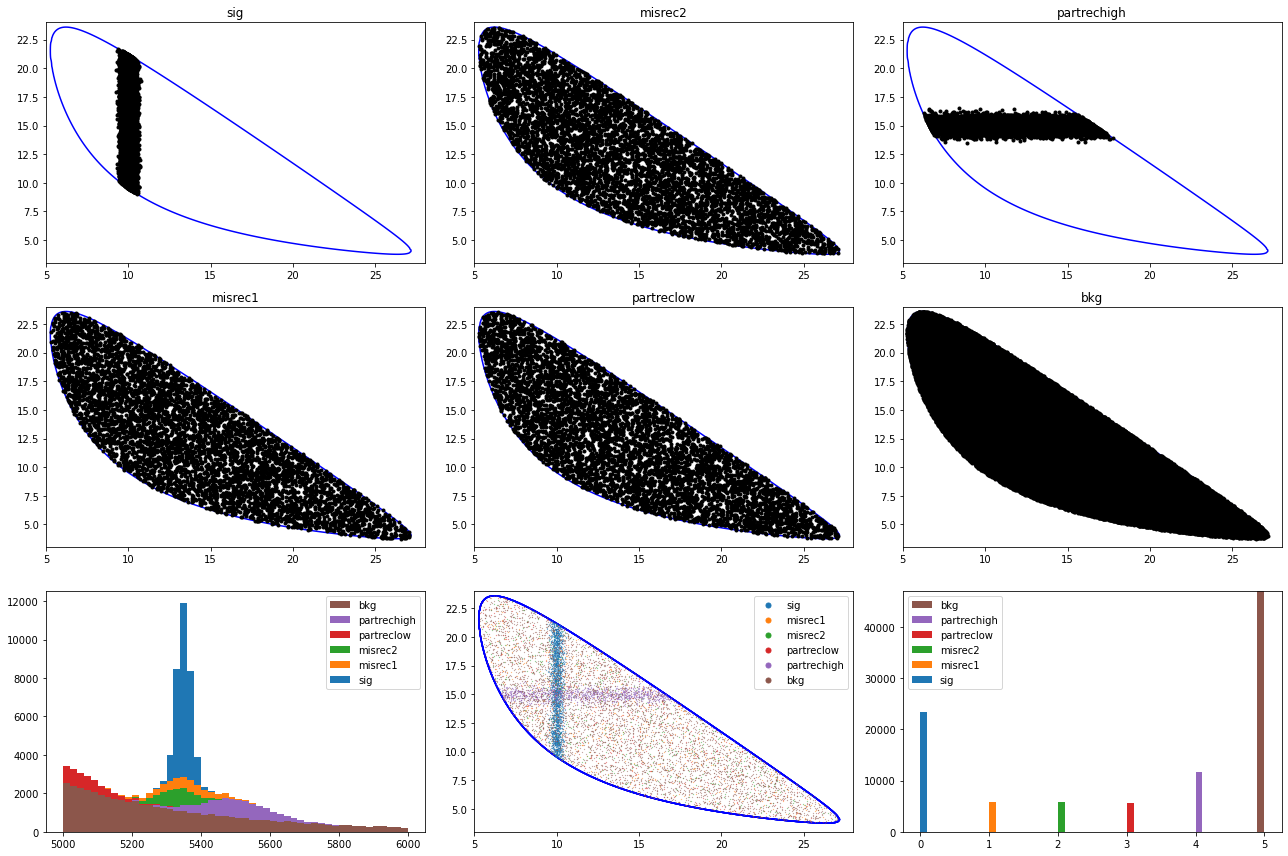

In [21]:
## plot the toy

fig, ax = plt.subplots(3, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames): 
    plax = ( i%2, int(i/2) )
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
    dslice = data[data['ctrl']==i]
    ax[plax].plot( dslice['m2ab'].to_numpy(), dslice['m2ac'].to_numpy(),'.', color='k' )
    ax[plax].set_title(comp)
    ax[2,1].plot( dslice['m2ab'].to_numpy()[::10], dslice['m2ac'].to_numpy()[::10], '.' , markersize=0.4,  label=comp)
    ax[2,1].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
    
legend = ax[2,1].legend(frameon=True)
cols = []
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(10)
    cols.append(legend_handle._legmarker.get_color())
    
ax[2,0].hist( tuple( data[data['ctrl']==i]['mass'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=mrange, stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[2,0].legend()

ax[2,2].hist( tuple( data[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=(0,len(compnames)-1), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[2,2].legend()

fig.tight_layout()
fig.savefig('figs/ex2_toy.pdf')


## Now fit the data

Going to fix all the shapes for simplicity but note these could be changed

In [5]:
from iminuit import Minuit

def nll(sigy, misrec1y, misrec2y, partreclowy, partrechighy, bkgy):
    
    s = pdf_dic['sig']
    mr1 = pdf_dic['misrec1']
    mr2 = pdf_dic['misrec2']
    pr1 = pdf_dic['partreclow']
    pr2 = pdf_dic['partrechigh']
    b = pdf_dic['bkg']
    sn = np.diff( s.cdf(mrange))
    bn = np.diff( b.cdf(mrange))
    mr1n = np.diff( mr1.cdf(mrange))
    mr2n = np.diff( mr2.cdf(mrange))
    pr1n = np.diff( pr1.cdf(mrange))
    pr2n = np.diff( pr2.cdf(mrange))
    no = sigy + bkgy + misrec1y + misrec2y + partreclowy + partrechighy
    ne = np.sum(np.log(s.pdf(data['mass'].to_numpy()) / sn * sigy + 
                       b.pdf(data['mass'].to_numpy()) / bn * bkgy +
                       mr1.pdf(data['mass'].to_numpy()) / mr1n * misrec1y +
                       mr2.pdf(data['mass'].to_numpy()) / mr2n * misrec2y +
                       pr1.pdf(data['mass'].to_numpy()) / pr1n * partreclowy +
                       pr2.pdf(data['mass'].to_numpy()) / pr2n * partrechighy
                      )
               )
    
    #nev = sum( [ np.log(pdf.pdf(data['mass'].to_numpy))])
    #ne = np.sum( np.log( pdfs[0].pdf(data['mass'].to_numpy())))
    #ne = np.sum(sum([np.log(pdf.pdf(data['mass'].to_numpy()) / pdf_norms[i] * ylds[i]) for i,pdf in enumerate(pdfs)]))
    return no-ne

mikwargs = {}
for name in compnames:
    #if 'part' in name: continue
    mikwargs[name+'y'] = abs_ylds[name]
    mikwargs['limit_'+name+'y'] = (0.5*abs_ylds[name],2.5*abs_ylds[name])

# fix the misrec yields as we might do in an analysis
mikwargs['fix_misrec1y'] = True
mikwargs['fix_misrec2y'] = True
                 
mi = Minuit(nll, **mikwargs,
            errordef=Minuit.LIKELIHOOD,
            pedantic=False)
                 
display(mi.migrad())
mi.hesse()

# set the fitted yields as our yields
for comp in compnames:
    abs_ylds[comp] = mi.values[comp+'y']
    


------------------------------------------------------------------
| FCN = -4.044E+05              |      Ncalls=94 (94 total)      |
| EDM = 6.34E-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------
| 0 | sigy         |  2.345E4  |  0.019E4  |            |            | 11764.7 | 58823.5 |       |
| 1 | misrec1y     |  0.588E4  |  0.000E4  |            |            | 2941.18 | 14705.9 |  yes  |
| 2 | misrec2y     |  0.588E4  |  0.000E4  |            |            | 2941.18 | 14705.9 |  yes  |
| 3 | partreclowy  |  0.588E4  |  0.026E4  |            |            | 2941.18 | 14705.9 |       |
| 4 | partrechighy |  1.192E4  |  0.021E4  |            |            | 5882.35 | 29411.8 |       |
| 5 | bkgy         |  0.468E5  |  0.005E5  |            |            | 23529.4 | 117647  |       |
--------------------------------------------------------------------------------------------------

## Now compute the sWeights

In [6]:
### Now do the sWeights
import importlib
import MySWeightClass
MySWeightClass = importlib.reload(MySWeightClass)
from MySWeightClass import SWeight


pdfs = [ pdf_dic[comp] for comp in compnames]
ylds = [ abs_ylds[comp] for comp in compnames]

sw = SWeight(data['mass'].to_numpy(), pdfs=pdfs, yields=ylds, method='summation', discvarranges=(mrange,), compnames=compnames)


Initialising SWeighter with the summation method:
    W-matrix:
	[[2.85381320e-05 1.15186600e-05 1.60585154e-05 5.84602949e-08
	  3.29398240e-06 2.75750926e-06]
	 [1.15186600e-05 1.90352085e-05 1.87058131e-05 1.39916071e-06
	  1.14118534e-05 7.73156721e-06]
	 [1.60585154e-05 1.87058131e-05 2.36222347e-05 7.77714008e-07
	  5.34164164e-06 6.45967494e-06]
	 [5.84602949e-08 1.39916071e-06 7.77714008e-07 3.84963946e-05
	  1.21838463e-07 1.62080447e-05]
	 [3.29398240e-06 1.14118534e-05 5.34164164e-06 1.21838463e-07
	  3.34023910e-05 9.09907705e-06]
	 [2.75750926e-06 7.73156721e-06 6.45967494e-06 1.62080447e-05
	  9.09907705e-06 1.38598075e-05]]
    alpha-matrix:
	[[  59580.35496678   21229.66499801  -60294.78512834   -7590.92777744
	    -8618.06652568   18939.89491432]
	 [  21229.66499801  405874.98778413 -303353.41872627   15680.58839429
	   -76716.91274305  -57224.80962678]
	 [ -60294.78512834 -303353.41872627  316153.31470867   17480.05345683
	    67350.95257498  -30789.45092514]
	 [  -75

/Users/matt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


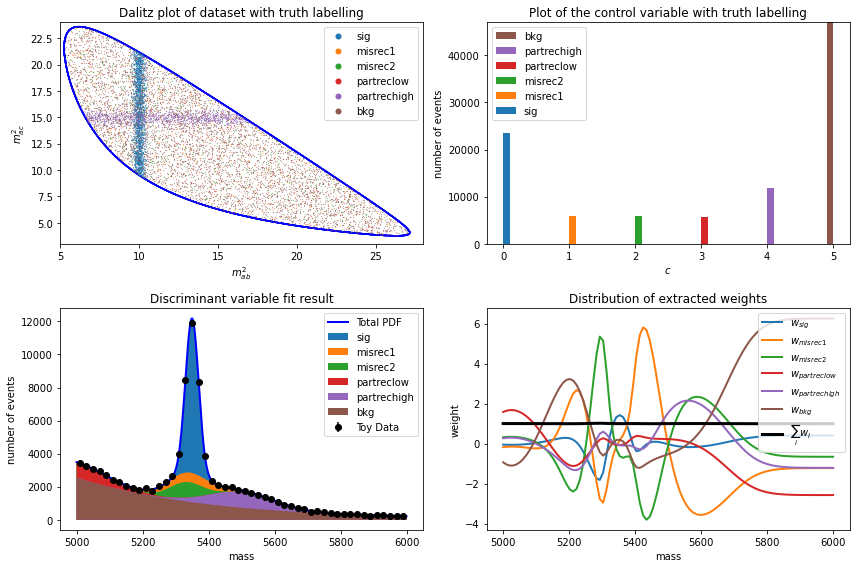

In [27]:
## Now make a plot of the fit result and sweights (include the truth for the paper)

fig, ax = plt.subplots(2,2,figsize=(12,8))

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames): 
    dslice = data[data['ctrl']==i]
    ax[0,0].plot( dslice['m2ab'].to_numpy()[::10], dslice['m2ac'].to_numpy()[::10], '.' , markersize=0.4,  label=comp)
    ax[0,0].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
    ax[0,0].set_title('Dalitz plot of dataset with truth labelling')
    ax[0,0].set_xlabel('$m^{2}_{ab}$')
    ax[0,0].set_ylabel('$m^{2}_{ac}$')
    
legend = ax[0,0].legend(frameon=True)
cols = []
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(10)
    cols.append(legend_handle._legmarker.get_color())
    
#ax[2,0].hist( tuple( data[data['ctrl']==i]['mass'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=mrange, stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
#ax[2,0].legend()

ax[0,1].hist( tuple( data[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=(0,len(compnames)-1), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[0,1].legend()
ax[0,1].set_title('Plot of the control variable with truth labelling')
ax[0,1].set_xlabel('$c$')
ax[0,1].set_ylabel('number of events')

# draw the fit result

w, xe = np.histogram( data['mass'].to_numpy(), bins=50, range=mrange )
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
x = np.linspace(*mrange,1000)
pdfnorm = (mrange[1]-mrange[0])/50

rcomps = list(compnames)
for comp in compnames: 
    ax[1,0].fill_between(x, pdfnorm*pdf(x, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[1,0].errorbar( cx, w, w**0.5, fmt='ko', label='Toy Data')
ax[1,0].plot( x, pdfnorm*pdf(x),'b-', linewidth=2, label='Total PDF')
ax[1,0].legend()
ax[1,0].set_title('Discriminant variable fit result')
ax[1,0].set_xlabel('mass')
ax[1,0].set_ylabel('number of events')

dopts = [ c for c in cols]
sw.makeWeightPlot(ax[1,1],dopts)
ax[1,1].set_title('Distribution of extracted weights')
ax[1,1].set_xlabel('mass')
ax[1,1].set_ylabel('weight')

fig.tight_layout()

fig.savefig('figs/ex2_dists.pdf')


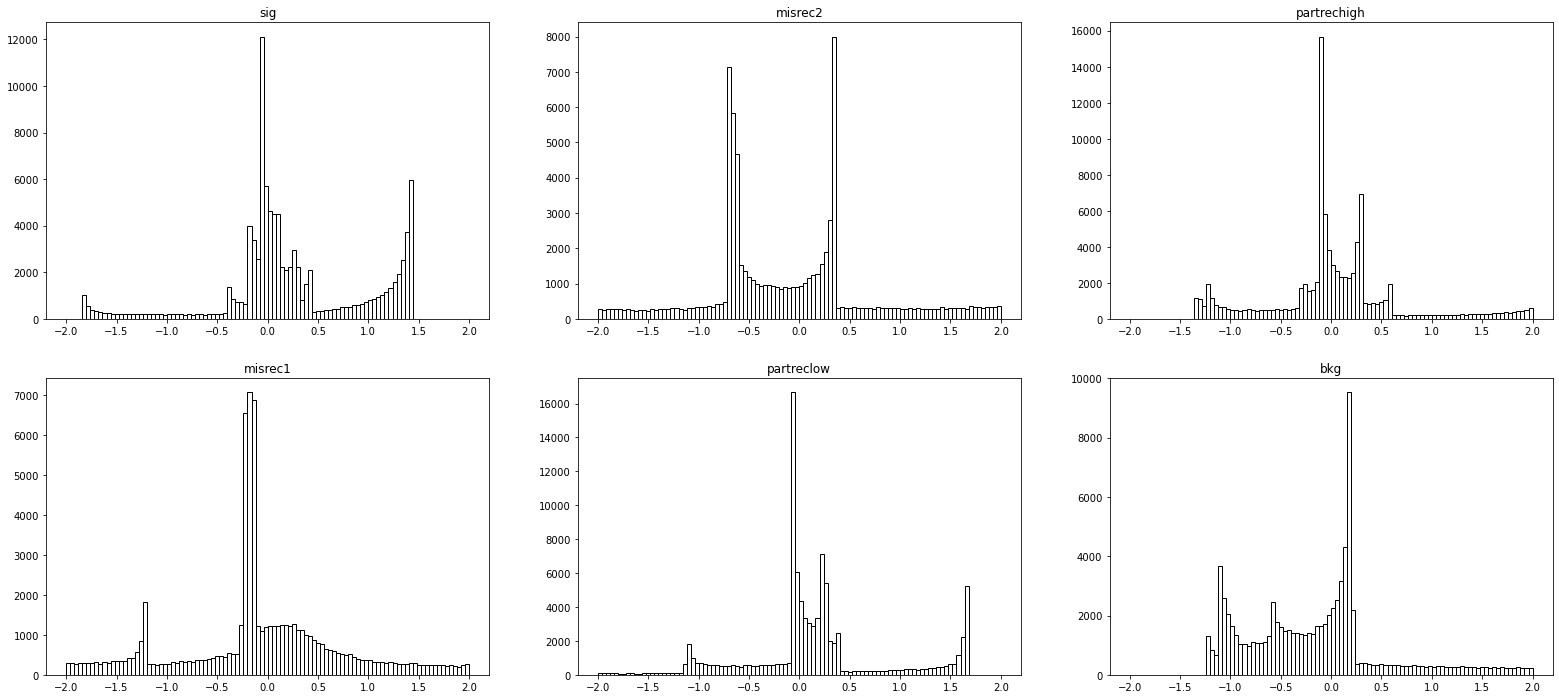

In [8]:
### Look at the distribution of the weights themselves
fig, ax = plt.subplots(2, 3, figsize=(27,12))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    ax[plax].hist( sw.getWeight(i,data['mass'].to_numpy()), bins=100, range=(-2,2.), fill=False)
    ax[plax].set_title(comp)

/Users/matt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Component    | SW       | SumSW    | Fit      | Truth    |
__________________________________________________________
sig          | 23467.16 | 23450.97 | 23450.97 | 23494.00 |
misrec1      |  5875.38 |  5882.35 |  5882.35 |  5843.00 |
misrec2      |  6252.53 |  5882.35 |  5882.35 |  5917.00 |
partreclow   |  5713.06 |  5884.77 |  5884.77 |  5721.00 |
partrechigh  | 11756.18 | 11916.47 | 11916.47 | 11774.00 |
bkg          | 46615.19 | 46757.20 | 46757.20 | 46988.00 |


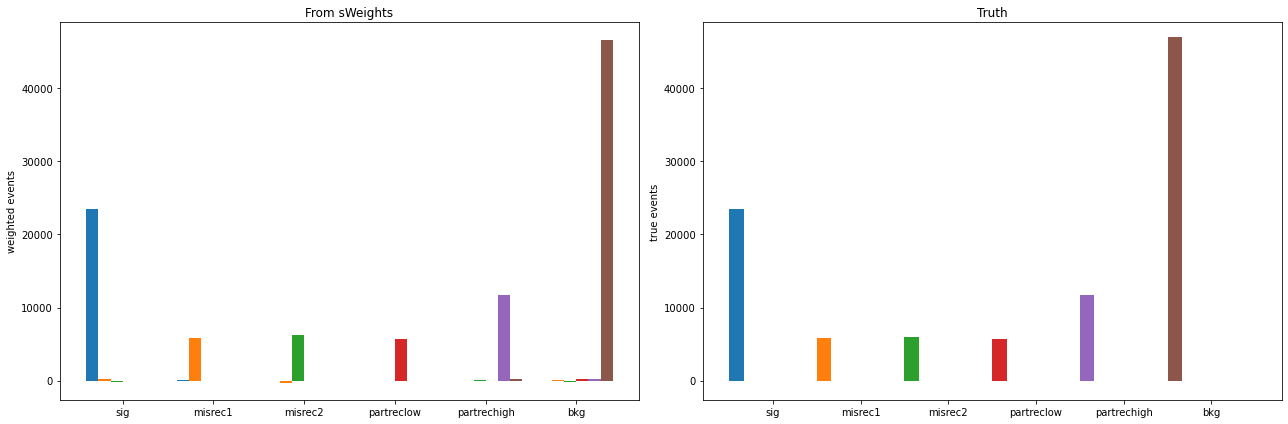

In [28]:
### Now look at sweighted distributions of ctrl variables

fig, ax = plt.subplots(1,2,figsize=(18,6))

xlabpos = [ i+0.5 for i in range(len(compnames)) ]

dum1 = ax[0].hist( [data['ctrl'].to_numpy() for i in compnames], bins=6, range=(0,6), weights=[sw.getWeight(i, data['mass'].to_numpy()) for i, comp in enumerate(compnames)])
ax[0].set_title("From sWeights")
ax[0].set_xticks(xlabpos)
ax[0].set_xticklabels(compnames)
ax[0].set_ylabel('weighted events')


dum2 = ax[1].hist( tuple( data[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Truth")
ax[1].set_xticks(xlabpos)
ax[1].set_xticklabels(compnames)
ax[1].set_ylabel('true events')

fig.tight_layout()
fig.savefig('figs/ex2_ctrlwts.pdf')

head = '{:12s} | {:8s} | {:8s} | {:8s} | {:8s} |'.format('Component','SW','SumSW','Fit','Truth')
print(head)
print( '_'.join([ '' for i in range(len(head)+1) ]))
for i, comp in enumerate(compnames):
    print('{:12s} |'.format(comp), 
          '{:8.2f} |'.format(dum1[0][i][i]), 
          '{:8.2f} |'.format(sum(dum1[0][i])),
          '{:8.2f} |'.format(abs_ylds[comp]), 
          '{:8.2f} |'.format(dum2[0][-1][i*6]))


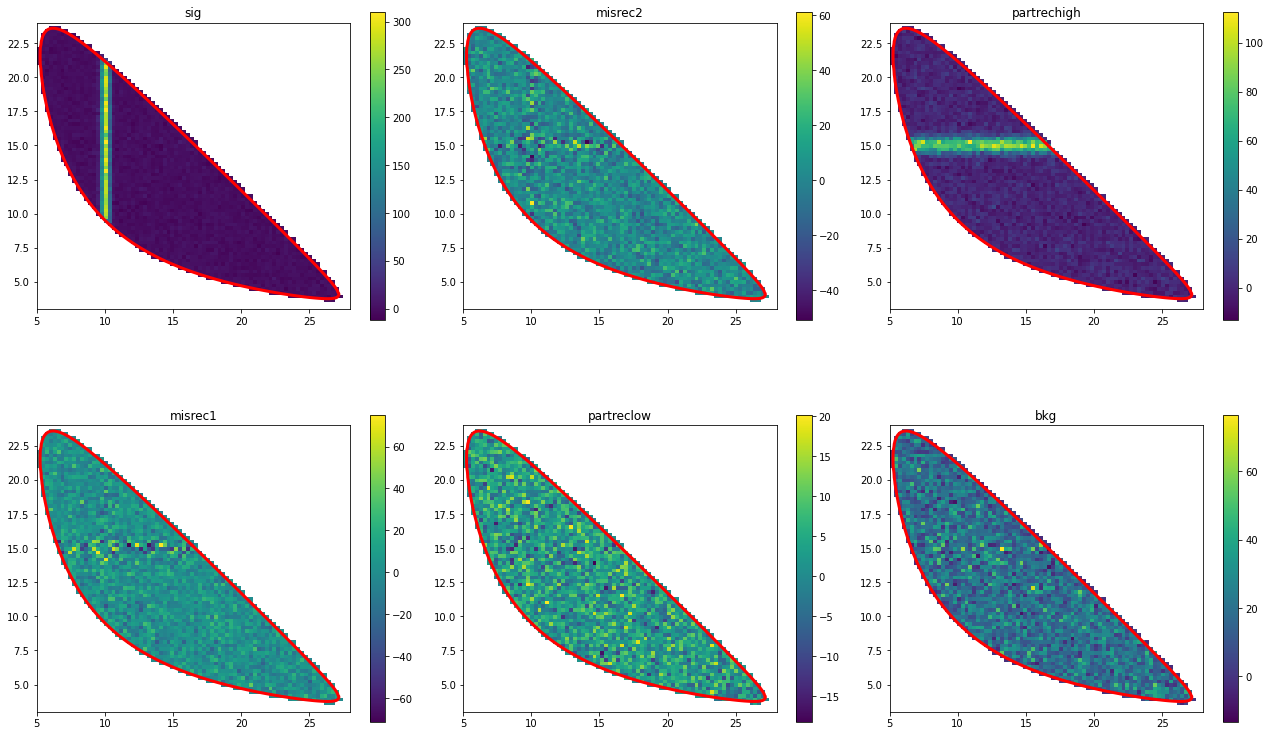

In [29]:
# dalitz plots of ctrl variables
from matplotlib import colors
fig, ax = plt.subplots(2, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    h, xe, ye = np.histogram2d( data['m2ab'].to_numpy(), data['m2ac'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=[80,80], range=(bdkp.abrange,bdkp.acrange) )
    h[h==0] = np.nan
    im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    ax[plax].set_title(comp)
    fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()
fig.savefig('figs/ex2_dalitz.pdf')



0 0 0
1 1 0
2 0 1
3 1 1
4 0 2
5 1 2


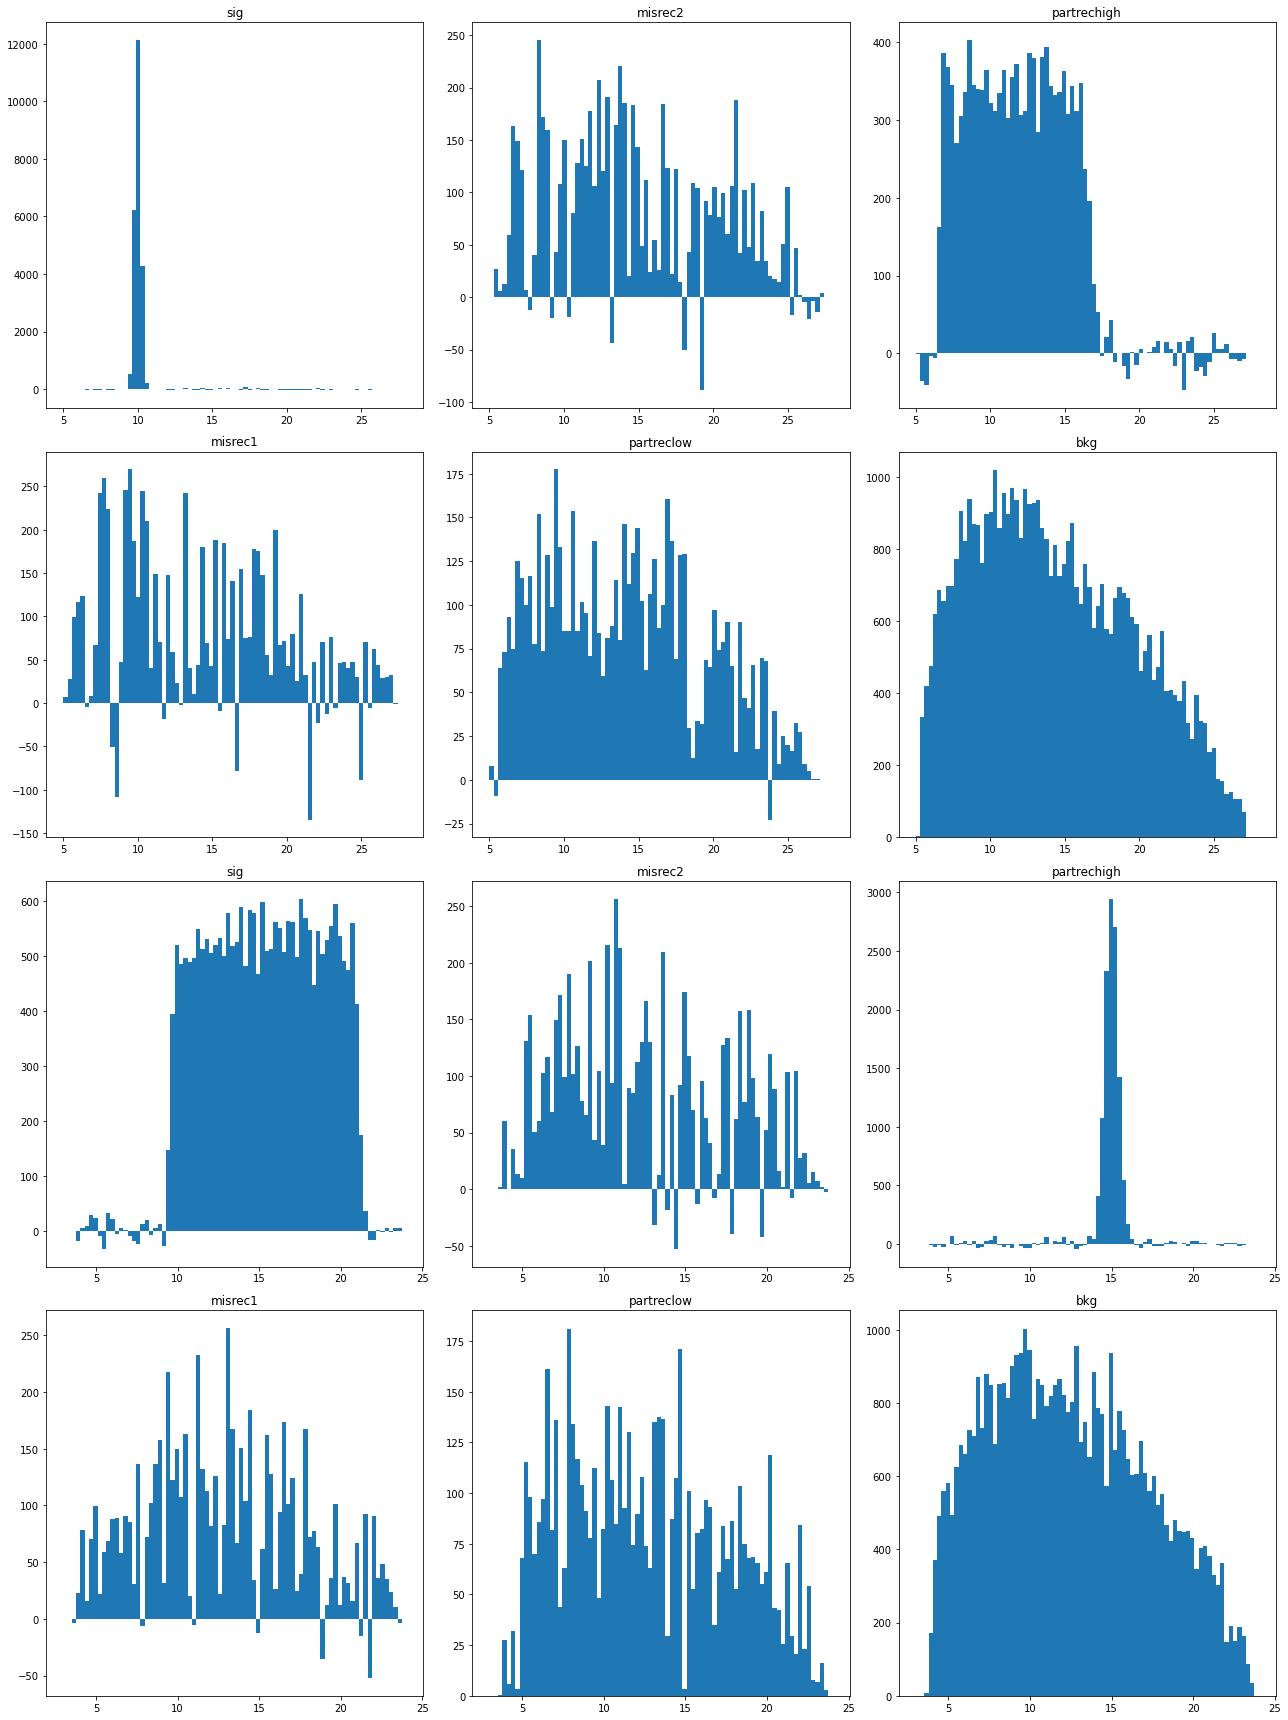

In [11]:
#1D projections
fig, ax = plt.subplots(4, 3, figsize=(18,24))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    play = (i%2 + 2, int(i/2) )
    print( i, i%2, int(i/2))
    #hx, xe = np.histogram( data['m2ab'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=80, range=bdkp.abrange )
    #hy, ye = np.histogram( data['m2ac'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=80, range=bdkp.acrange )
    
    ax[plax].hist( data['m2ab'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=80, range=bdkp.abrange )
    ax[play].hist( data['m2ac'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=80, range=bdkp.acrange )
    
    ax[plax].set_title(comp)
    ax[play].set_title(comp)

    #h[h==0] = np.nan
    #im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    #ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    #ax[plax].set_title(comp)
    #fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()

## Can now see what happens if we do this in a narrow range

Initialising SWeighter with the summation method:
    W-matrix:
	[[2.85381320e-05 1.16634422e-05 1.60611578e-05 4.37530015e-07
	  4.76849175e-06 5.82612720e-06]
	 [1.16634422e-05 1.94996108e-05 1.89438085e-05 9.13566513e-06
	  1.63230924e-05 1.61824854e-05]
	 [1.60611578e-05 1.89438085e-05 2.36300000e-05 5.78841094e-06
	  7.73364221e-06 1.36444382e-05]
	 [4.37530015e-07 9.13566513e-06 5.78841094e-06 1.08037240e-04
	  9.41710473e-07 3.61135980e-05]
	 [4.76849175e-06 1.63230924e-05 7.73364221e-06 9.41710473e-07
	  4.56743668e-05 1.68091813e-05]
	 [5.82612720e-06 1.61824854e-05 1.36444382e-05 3.61135980e-05
	  1.68091813e-05 2.35105284e-05]]
    alpha-matrix:
	[[  67410.85312814   -5954.36219914  -76225.54566183  -23386.24270511
	   -22232.21153198   83449.14814495]
	 [  -5954.36219914  765722.50804277 -391531.91557507   81207.82556694
	   -71524.89843085 -371952.55829204]
	 [ -76225.54566183 -391531.91557507  427458.48045805   50584.53033905
	   119727.99102972 -122995.5556797 ]
	 [ -233

(-4.0, 6.0)

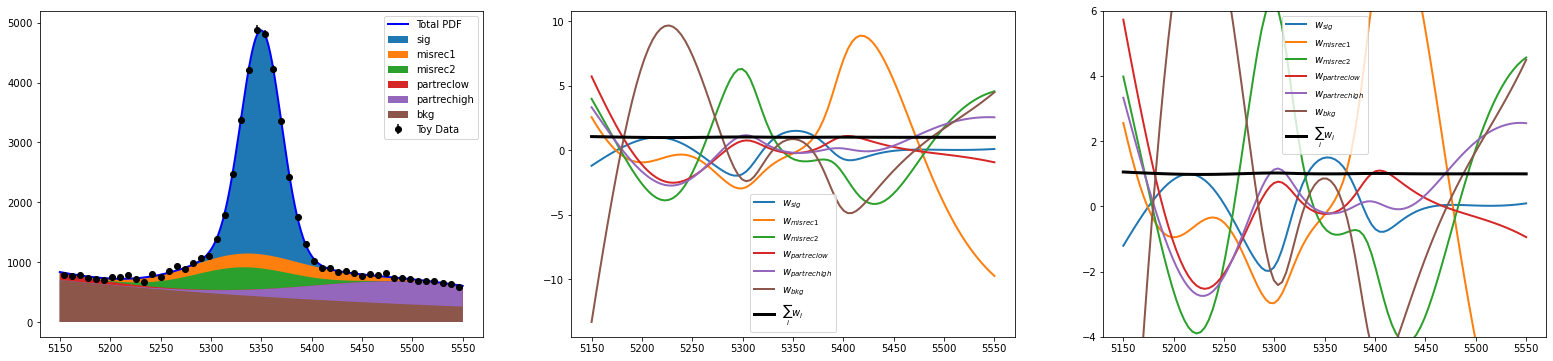

In [12]:
narrange  = ( pdf_vars['sig'][0] - 10.*pdf_vars['sig'][1], pdf_vars['sig'][0] + 10.*pdf_vars['sig'][1])
narylds   = [ ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) ]
narylddic = { comp: ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) }
narnorms  = { comp: np.diff( pdf_dic[comp].cdf(narrange))[0] for comp in compnames }

nardata = data.loc[ (data.mass >= narrange[0]) & (data.mass <= narrange[1]) ]

narsw = SWeight(nardata['mass'].to_numpy(), pdfs=pdfs, yields=narylds, method='summation', discvarranges=(narrange,), compnames=compnames)

## Now make a plot of the fit result and sweights
def narpdf(x, comps='all'):
    if comps=='all': comps = compnames
    return sum( [ narylddic[comp] * pdf_dic[comp].pdf(x) / narnorms[comp] for comp in comps ] )    

# draw the fit result
fig, ax = plt.subplots(1,3,figsize=(27,6))
w, xe = np.histogram( nardata['mass'].to_numpy(), bins=50, range=narrange )
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
x = np.linspace(*narrange,1000)
pdfnorm = (narrange[1]-narrange[0])/50

rcomps = list(compnames)
for i, comp in enumerate(compnames): 
    ax[0].fill_between(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    #ax[0].plot(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[0].errorbar( cx, w, w**0.5, fmt='ko', label='Toy Data')
ax[0].plot( x, pdfnorm*narpdf(x),'b-', linewidth=2, label='Total PDF')
ax[0].legend()

dopts = [ c for c in cols]
narsw.makeWeightPlot(ax[1],dopts)
narsw.makeWeightPlot(ax[2],dopts)
ax[2].set_ylim((-4,6))





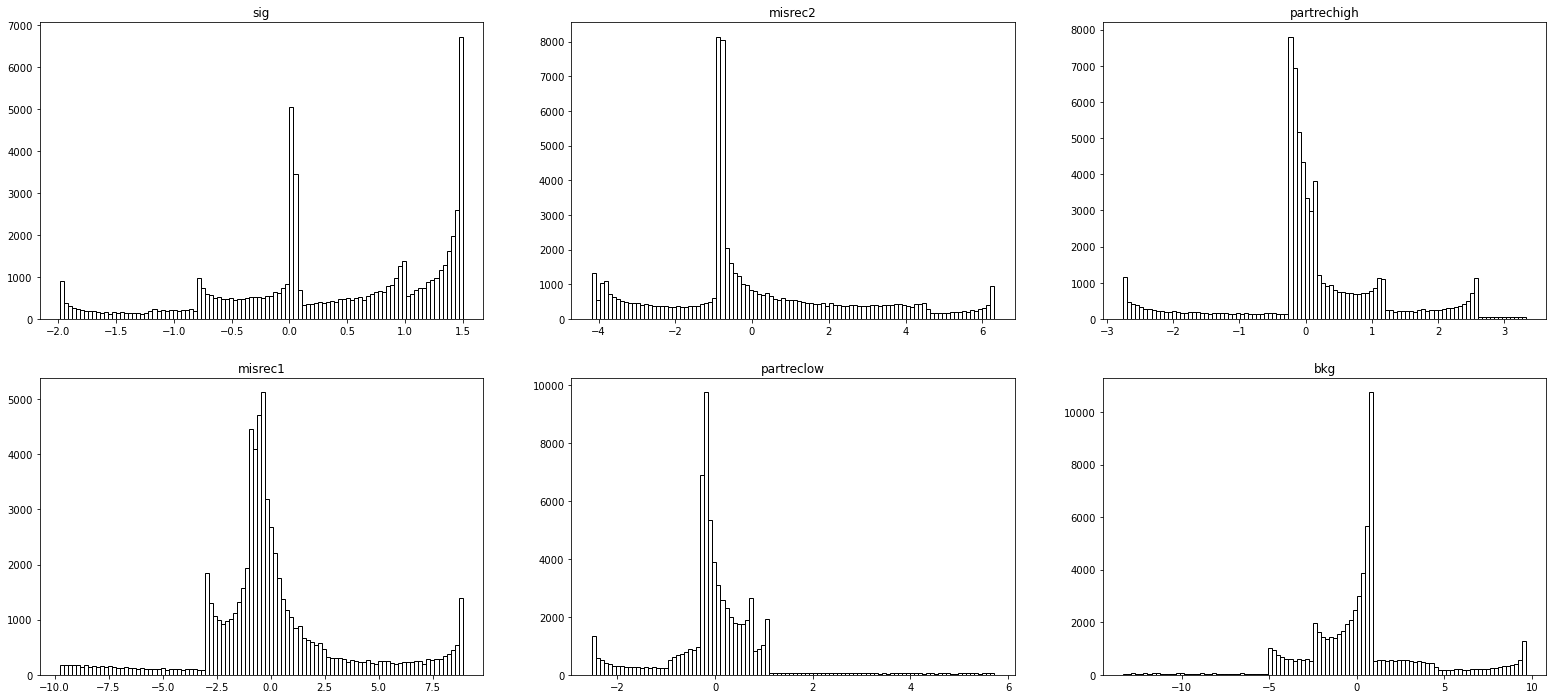

In [13]:
### Look at the distribution of the weights themselves
fig, ax = plt.subplots(2, 3, figsize=(27,12))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    ax[plax].hist( narsw.getWeight(i,nardata['mass'].to_numpy()), bins=100, fill=False)
    ax[plax].set_title(comp)

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be rein

Component    | SW       | SumSW    | Fit      | Truth    |
__________________________________________________________
sig          | 23455.46 | 23450.97 | 23450.97 | 23494.00 |
misrec1      |  5838.09 |  5809.33 |  5809.33 |  5768.00 |
misrec2      |  6269.29 |  5881.39 |  5881.39 |  5917.00 |
partreclow   |   692.70 |   786.29 |   786.29 |   745.00 |
partrechigh  |  8074.43 |  8231.67 |  8231.67 |  8096.00 |
bkg          | 21979.65 | 22130.21 | 22130.21 | 22186.00 |


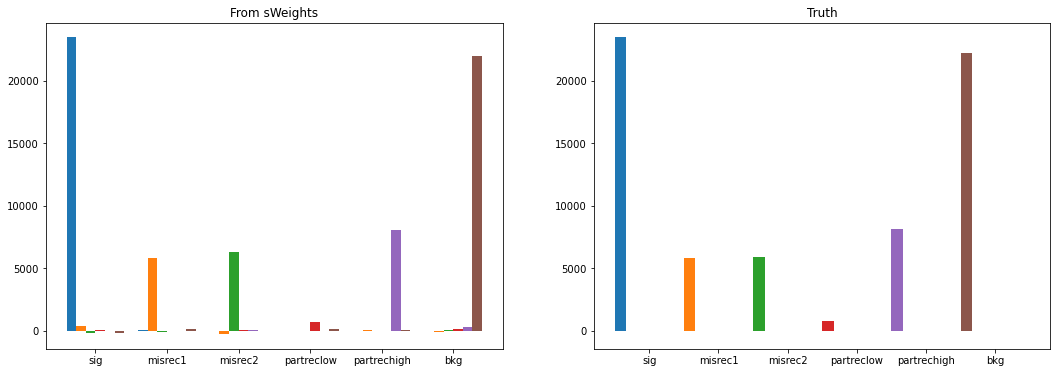

In [14]:
### Now look at sweighted distributions of ctrl variables

fig, ax = plt.subplots(1,2,figsize=(18,6))

xlabpos = [ i+0.5 for i in range(len(compnames)) ]

dum1 = ax[0].hist( [nardata['ctrl'].to_numpy() for i in compnames], bins=6, range=(0,6), weights=[narsw.getWeight(i, nardata['mass'].to_numpy()) for i, comp in enumerate(compnames)])
ax[0].set_title("From sWeights")
ax[0].set_xticks(xlabpos)
ax[0].set_xticklabels(compnames)

dum2 = ax[1].hist( tuple( nardata[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Truth")
ax[1].set_xticks(xlabpos)
ax[1].set_xticklabels(compnames)

head = '{:12s} | {:8s} | {:8s} | {:8s} | {:8s} |'.format('Component','SW','SumSW','Fit','Truth')
print(head)
print( '_'.join([ '' for i in range(len(head)+1) ]))
for i, comp in enumerate(compnames):
    print('{:12s} |'.format(comp), 
          '{:8.2f} |'.format(dum1[0][i][i]), 
          '{:8.2f} |'.format(sum(dum1[0][i])),
          '{:8.2f} |'.format(narylddic[comp]), 
          '{:8.2f} |'.format(dum2[0][-1][i*6]))



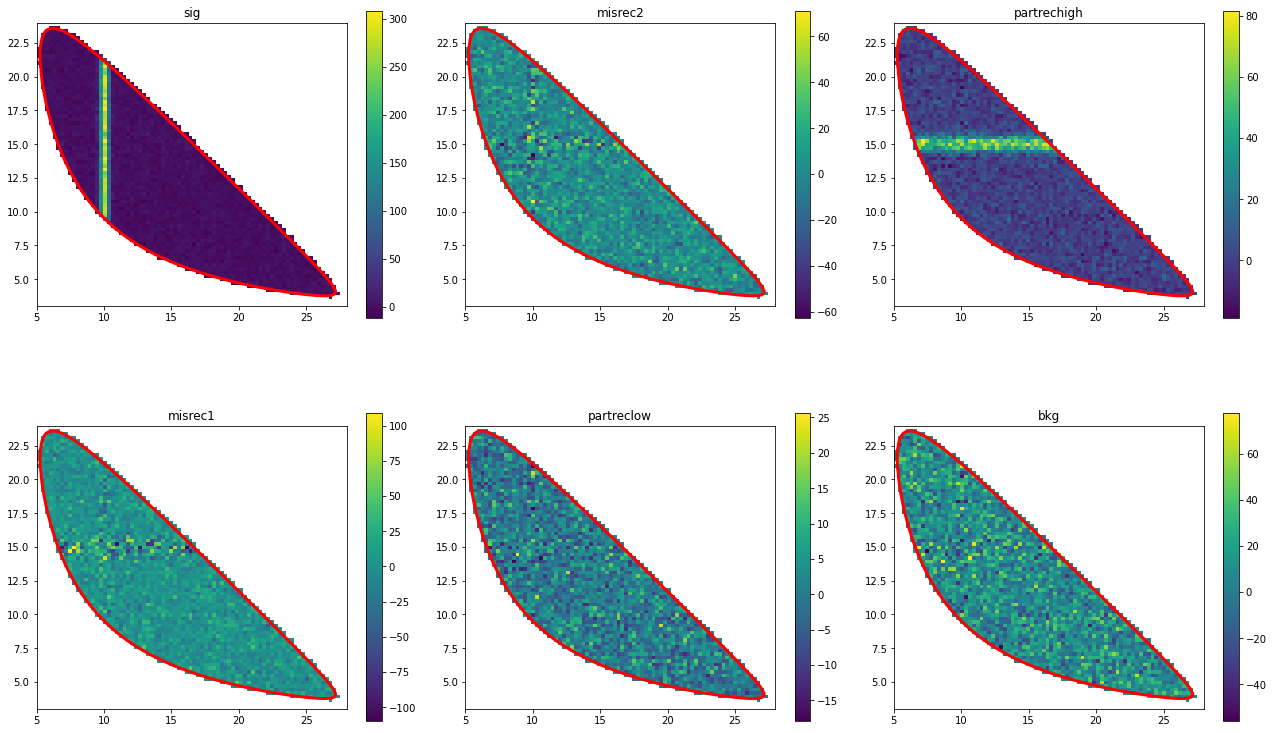

In [15]:
# dalitz plots of ctrl variables
from matplotlib import colors
fig, ax = plt.subplots(2, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    h, xe, ye = np.histogram2d( nardata['m2ab'].to_numpy(), nardata['m2ac'].to_numpy(), weights=narsw.getWeight(i, nardata['mass'].to_numpy()), bins=[80,80], range=(bdkp.abrange,bdkp.acrange) )
    h[h==0] = np.nan
    im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    ax[plax].set_title(comp)
    fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()

### Even narrower range

Initialising SWeighter with the summation method:
    W-matrix:
	[[2.85381647e-05 1.46045105e-05 1.71381680e-05 4.70969094e-06
	  1.09047998e-05 1.20182648e-05]
	 [1.46045105e-05 2.59178437e-05 2.38230242e-05 3.16745195e-05
	  2.88399547e-05 2.75638488e-05]
	 [1.71381680e-05 2.38230242e-05 2.60874556e-05 3.50630572e-05
	  1.74965108e-05 2.55254958e-05]
	 [4.70969094e-06 3.16745195e-05 3.50630572e-05 1.37410187e-04
	  9.27419472e-06 4.82118680e-05]
	 [1.09047998e-05 2.88399547e-05 1.74965108e-05 9.27419472e-06
	  5.53666489e-05 2.87049909e-05]
	 [1.20182648e-05 2.75638488e-05 2.55254958e-05 4.82118680e-05
	  2.87049909e-05 3.17895951e-05]]
    alpha-matrix:
	[[   178057.10812559   -353233.42199428   -804525.56615847
	    -314758.06514097   -470820.6828379    1787453.62249869]
	 [  -353233.42199428   6381572.55661878   -700890.00089521
	     960422.71143644    129700.24945085  -6410641.61789365]
	 [  -804525.56615847   -700890.00089521   7318751.08780831
	    2426053.07879522   4297969.0

(-4.0, 6.0)

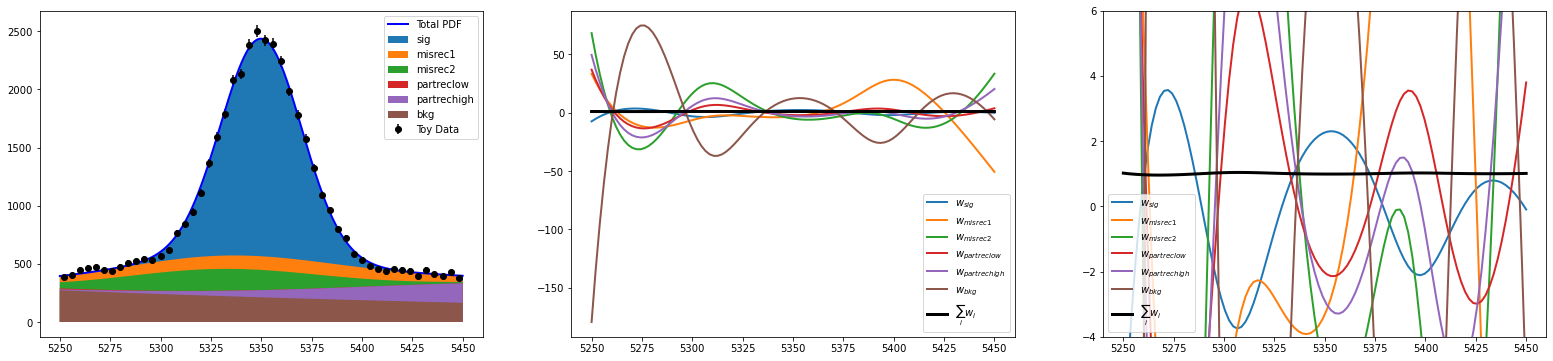

In [16]:
narrange  = ( pdf_vars['sig'][0] - 5.*pdf_vars['sig'][1], pdf_vars['sig'][0] + 5.*pdf_vars['sig'][1])
narylds   = [ ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) ]
narylddic = { comp: ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) }
narnorms  = { comp: np.diff( pdf_dic[comp].cdf(narrange))[0] for comp in compnames }

nardata = data.loc[ (data.mass >= narrange[0]) & (data.mass <= narrange[1]) ]

narsw = SWeight(nardata['mass'].to_numpy(), pdfs=pdfs, yields=narylds, method='summation', discvarranges=(narrange,), compnames=compnames)

## Now make a plot of the fit result and sweights
def narpdf(x, comps='all'):
    if comps=='all': comps = compnames
    return sum( [ narylddic[comp] * pdf_dic[comp].pdf(x) / narnorms[comp] for comp in comps ] )    

# draw the fit result
fig, ax = plt.subplots(1,3,figsize=(27,6))
w, xe = np.histogram( nardata['mass'].to_numpy(), bins=50, range=narrange )
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
x = np.linspace(*narrange,1000)
pdfnorm = (narrange[1]-narrange[0])/50

rcomps = list(compnames)
for i, comp in enumerate(compnames): 
    ax[0].fill_between(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    #ax[0].plot(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[0].errorbar( cx, w, w**0.5, fmt='ko', label='Toy Data')
ax[0].plot( x, pdfnorm*narpdf(x),'b-', linewidth=2, label='Total PDF')
ax[0].legend()

dopts = [ c for c in cols]
narsw.makeWeightPlot(ax[1],dopts)
narsw.makeWeightPlot(ax[2],dopts)
ax[2].set_ylim((-4,6))






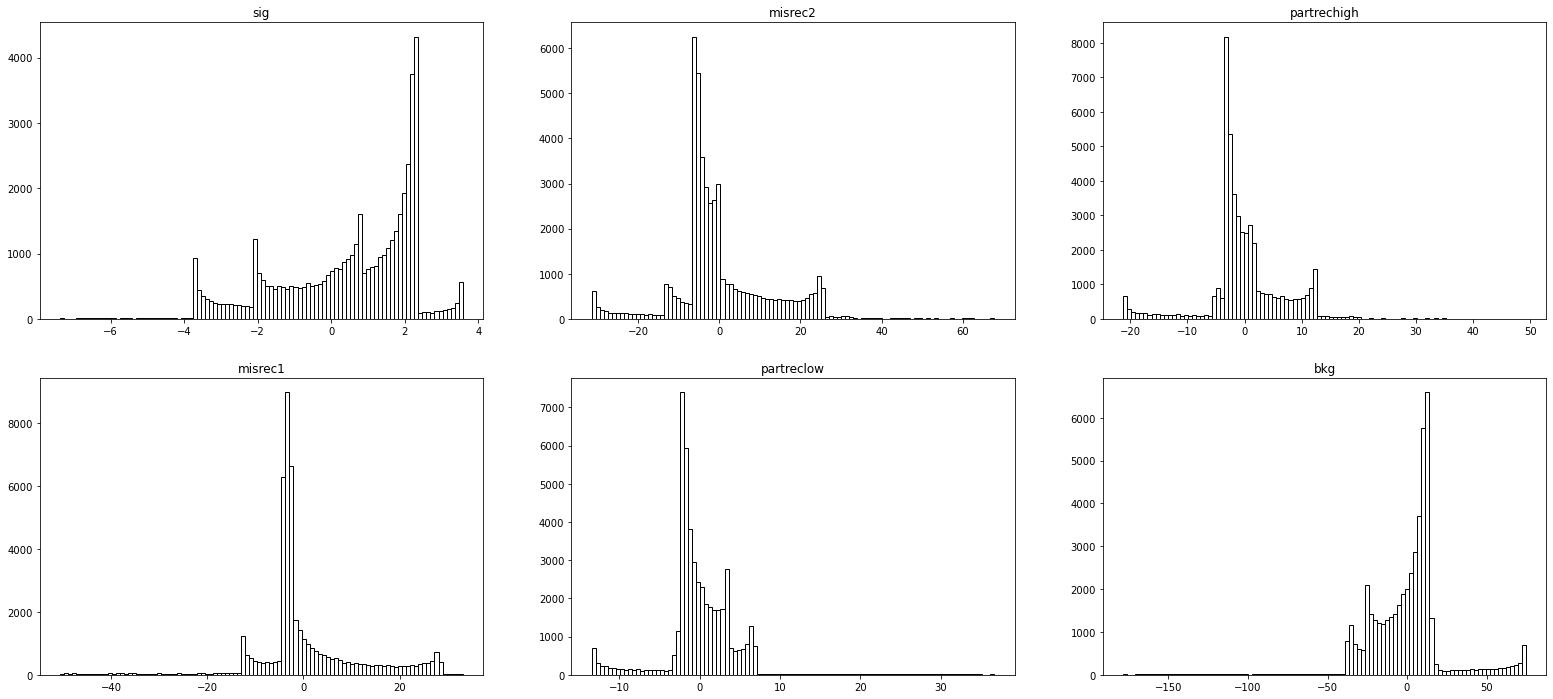

In [17]:
### Look at the distribution of the weights themselves
fig, ax = plt.subplots(2, 3, figsize=(27,12))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    ax[plax].hist( narsw.getWeight(i,nardata['mass'].to_numpy()), bins=100, fill=False)
    ax[plax].set_title(comp)

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be rein

Component    | SW       | SumSW    | Fit      | Truth    |
__________________________________________________________
sig          | 23441.56 | 23450.95 | 23450.95 | 23494.00 |
misrec1      |  3997.40 |  4639.44 |  4639.44 |  4595.00 |
misrec2      |  6805.75 |  5511.78 |  5511.78 |  5569.00 |
partreclow   |   131.91 |    73.04 |    73.04 |    82.00 |
partrechigh  |  2743.87 |  3599.57 |  3599.57 |  3518.00 |
bkg          |  9553.21 | 10728.10 | 10728.10 | 10662.00 |


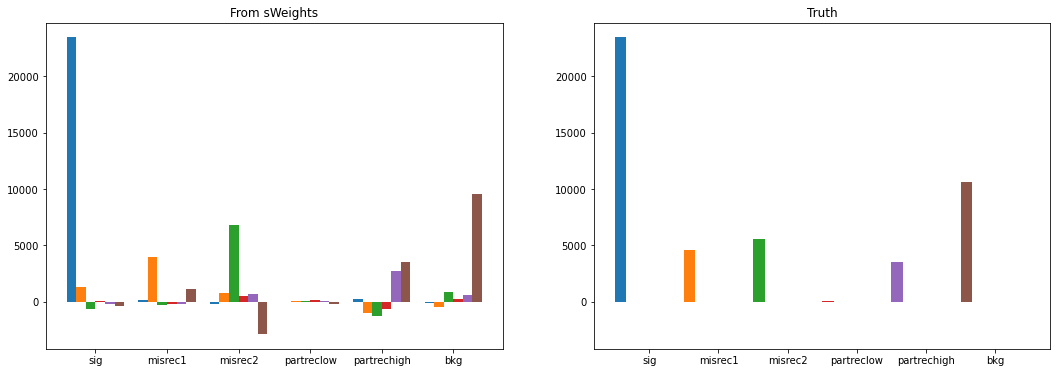

In [18]:
### Now look at sweighted distributions of ctrl variables

fig, ax = plt.subplots(1,2,figsize=(18,6))

xlabpos = [ i+0.5 for i in range(len(compnames)) ]

dum1 = ax[0].hist( [nardata['ctrl'].to_numpy() for i in compnames], bins=6, range=(0,6), weights=[narsw.getWeight(i, nardata['mass'].to_numpy()) for i, comp in enumerate(compnames)])
ax[0].set_title("From sWeights")
ax[0].set_xticks(xlabpos)
ax[0].set_xticklabels(compnames)

dum2 = ax[1].hist( tuple( nardata[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Truth")
ax[1].set_xticks(xlabpos)
ax[1].set_xticklabels(compnames)

head = '{:12s} | {:8s} | {:8s} | {:8s} | {:8s} |'.format('Component','SW','SumSW','Fit','Truth')
print(head)
print( '_'.join([ '' for i in range(len(head)+1) ]))
for i, comp in enumerate(compnames):
    print('{:12s} |'.format(comp), 
          '{:8.2f} |'.format(dum1[0][i][i]), 
          '{:8.2f} |'.format(sum(dum1[0][i])),
          '{:8.2f} |'.format(narylddic[comp]), 
          '{:8.2f} |'.format(dum2[0][-1][i*6]))



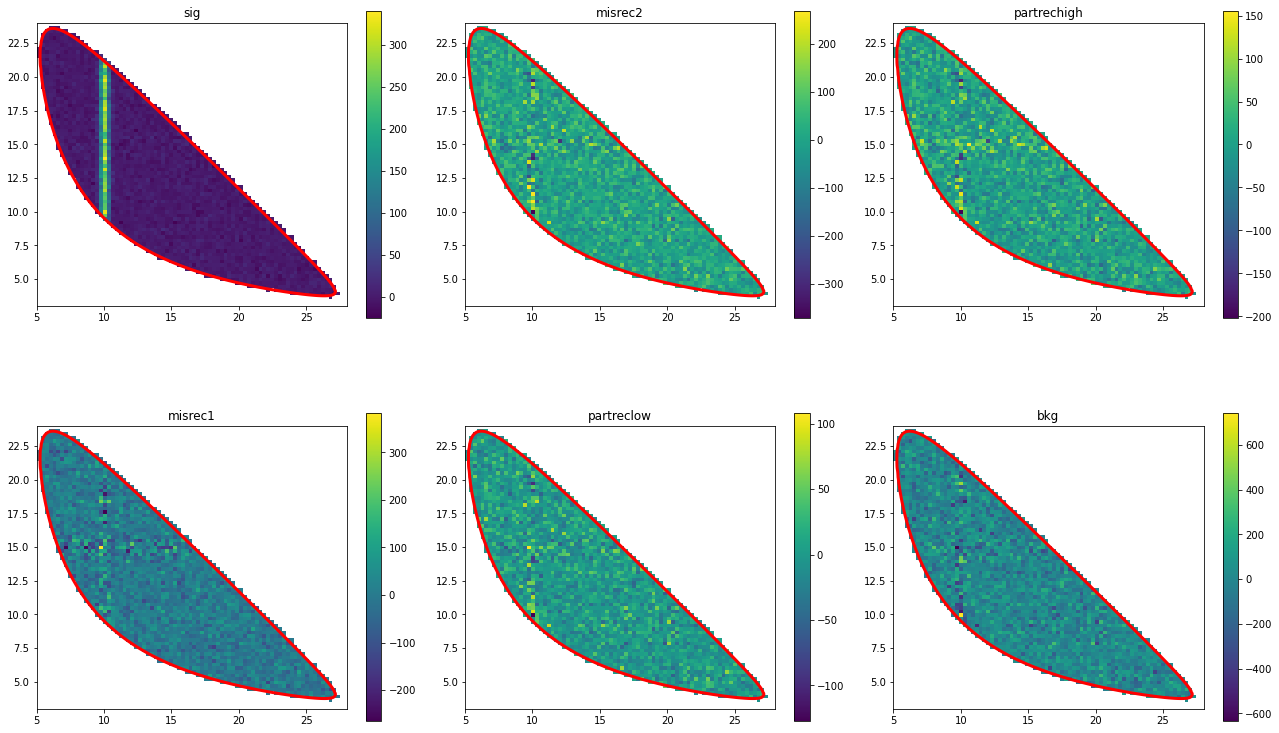

In [19]:
# dalitz plots of ctrl variables
from matplotlib import colors
fig, ax = plt.subplots(2, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    h, xe, ye = np.histogram2d( nardata['m2ab'].to_numpy(), nardata['m2ac'].to_numpy(), weights=narsw.getWeight(i, nardata['mass'].to_numpy()), bins=[80,80], range=(bdkp.abrange,bdkp.acrange) )
    h[h==0] = np.nan
    im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    ax[plax].set_title(comp)
    fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()